## Imports

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [44]:
from IPython.display import display
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.string_edit_metrics import get_string_edit_metrics

sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/word_level_kd/ami_100h")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [80]:
df = pd.read_json("notebooks/data/json_preds/word_level-ami-preds_orthographic.json")

df["len_pred"] = df["predictions"].str.split().str.len()
df["len_ref"] = df["references"].str.split().str.len()
df["n_exceeding_words"] = df["len_pred"] - df["len_ref"]

df.sort_values("len_pred", ascending=False)

,references,predictions,len_pred,len_ref,n_exceeding_words
2603,oh yeah yeah it'll yeah yeah,oh yeah yeah yeah yeah yeah yeah yeah yeah yea...,221,6,215
3482,yeah i should have more to talk about,yeah yeah yeah yeah yeah yeah yeah yeah yeah y...,221,8,213
455,uh,ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ...,221,1,220
4935,yeah exactly,yeah yeah yeah yeah yeah yeah yeah yeah yeah y...,221,2,219
9518,cel celebration yes yes,yeah yeah yeah yeah yeah yeah yeah yeah yeah y...,221,4,217
...,...,...,...,...,...
5880,yeah,yep,1,1,0
5875,yeah,yeah,1,1,0
5874,okay,okay,1,1,0
5871,mm-hmm,mm-hmm,1,1,0


Figure saved at `notebooks/outputs/word_level_kd/ami_100h/pairplot_n_words.png`.


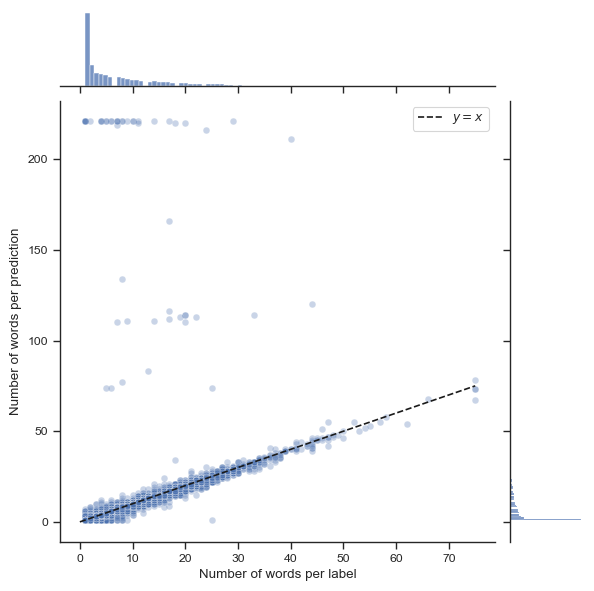

In [81]:
x_col = "len_ref"
y_col = "len_pred"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.3)

line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'k--', label=r"$y=x$")

plt.legend()
plt.xlabel("Number of words per label")
plt.ylabel("Number of words per prediction")

savepath = OUTPUT_DIR / "pairplot_n_words.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

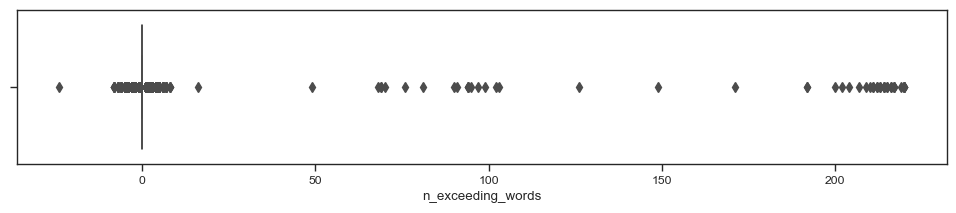

In [82]:
plt.figure(figsize=(12, 2))
sns.boxplot(data=df, x="n_exceeding_words");

In [83]:
for n in [2, 5, 10, 20, 50]:
    print(n)
    print(f'{(df["n_exceeding_words"] > n).mean():.3%}')
    print()

2
1.598%

5
0.538%

10
0.403%

20
0.395%

50
0.388%



In [84]:
cols_to_show = ["references", "predictions"]

with pd.option_context('display.max_colwidth', None):
    display(df.loc[df["n_exceeding_words"] > 50, cols_to_show])

,references,predictions
195,t throw stuff throwing out the window,uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh
363,yeah yeah 'cause that's the uh the declares a variable doesn't it and then they keep okay,yeah yeah because that's the the the g like it the the class is very modern isn't it i mean the t. c. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p
416,the k the f there's computer rooms in here the m. s. c. computer lab and uh is in here,the f f this computer rooms in here the m. s. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c.
455,uh,ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha
544,yeah that's it's quite impressive actually,yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes
773,well should you find you want to explore any other perhaps you as your um uh quantify raising,well should you find it what to explore any other ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha

In [85]:
get_string_edit_metrics(references=df["references"], predictions=df["predictions"])

{'wer': 0.30505431267146965,
 'sub': 0.1366627261169228,
 'del': 0.050085874244418176,
 'ins': 0.1183057123101287}

In [88]:
df_filtered = df[df["n_exceeding_words"] <= 50]

In [89]:
get_string_edit_metrics(references=df_filtered["references"], predictions=df_filtered["predictions"])

{'wer': 0.21067936094488543,
 'sub': 0.13337973930323682,
 'del': 0.050342992511423726,
 'ins': 0.026956629130224882}

## Comparison

In [74]:
from typing import Dict

def load_from_df_filepaths(df_filepaths: Dict[str, str]) -> pd.DataFrame:
    list_df = [pd.read_json(filepath)["predictions"].rename(col_name) for col_name, filepath in df_filepaths.items()]
    ref = pd.read_json(next(iter(df_filepaths.values())))["references"]
    list_df.append(ref)
    df = pd.concat(list_df, axis=1)
    return df

In [79]:
df_filepaths = {
    "student_finetuned": "outputs/finetuning/whisper_tiny/ami_100h/checkpoint-3000-ami_test-preds_orthographic.json",
    "teacher_vanilla": "outputs/vanilla/medium/whisper-medium-ami_test-preds_orthographic.json",
    "word_level": "notebooks/data/json_preds/word_level-ami-preds_orthographic.json"
}

df_comparison = load_from_df_filepaths(df_filepaths)

df_comparison

,student_finetuned,teacher_vanilla,word_level,references
0,b,no.,mm,yeah
1,mm-hmm,mm-hmm.,mm-hmm,mm-hmm
2,yeah we were gonna meet up,"yeah, we're going to meet up.",yeah we were gonna meet up,yeah we're gonna meet up
3,i mean we're not even there yet,"i mean, we're not even there yet.",i mean we're not even there yeah,i mean we're not even there yet
4,yeah,yeah.,yeah,yeah
...,...,...,...,...
12638,f. a. thin buttons,15 buttons,f. the buttons,fifteen buttons
12639,four or five between,four or five in between.,four or five between,four or five between
12640,mm-hmm,mm-hmm.,mm-hmm,mm-hmm
12641,um yeah maybe um uh when we uh just uh gave th...,maybe just give the numbers of,um yeah maybe um uh uh uh uh uh just uh give ...,um yeah maybe um uh when we n uh just uh give ...


In [91]:
idx_hallucinations = df[df["n_exceeding_words"] > 50].index

In [95]:
cols_to_show = ["references", "student_finetuned", "teacher_vanilla", "word_level"]

with pd.option_context('display.max_colwidth', None):
    display(df_comparison.loc[idx_hallucinations, cols_to_show])

,references,student_finetuned,teacher_vanilla,word_level
195,t throw stuff throwing out the window,r,trust that drug i had to win.,uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh
363,yeah yeah 'cause that's the uh the declares a variable doesn't it and then they keep okay,yeah yeah because that's the the dark it the class of variable doesn't it i mean it can probably not do it,"yeah, yeah, because that's the guy declares a variable doesn't it?",yeah yeah because that's the the the g like it the the class is very modern isn't it i mean the t. c. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p. p
416,the k the f there's computer rooms in here the m. s. c. computer lab and uh is in here,the c the f this computer rooms in here the m. s. c. computer lab in it's in here,"there's computer rooms in here, the msc computer lab is in here.",the f f this computer rooms in here the m. s. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c. c.
455,uh,yeah,i'm sorry.,ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha
544,yeah that's it's quite impressive actually,yes yes,"yeah, that's quite impressive actually.",yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes yes
773,well should you find you want to explore any other perhaps you as your um uh quantify raising,well should you find it what to explore any other perhaps cache your as your um uh quantified razor,"well, should you finally want to explore any other? how's your quantifier raising?",well should